# 半监督欺诈识别实验
## 实验目标
1. 介绍使用半监督异常检测识别欺诈问题的实践。
2. 比较常见异常检测方法的优缺点，主要评价方式是：数据前期处理、训练速度、模型效果。
3. 模块化从数据准备、模型训练到效果评价的流程，提高建模效率、降低难度（黑箱）。

## 数据集
2013年近七天约**28万**笔信用卡交易数据（欧洲）,其中欺诈交易仅占了0.17%（492笔），是一个样本极不平衡的问题。

我们把492笔欺诈交易认为是黑样本， 剩余的认为是白样本。

## 实验模型
比较 多维高斯模型、混合高斯模型、孤立森林、单分类SVM 这些常用的异常检测的模型在该问题上的效果和性能。

## 模型训练方式
不同于有监督和无监督学习，这里半监督学习仅使用白样本学习模型（分布）， 利用黑样本来确定是否是异常的阈值， 以及测试效果。

## 评价方法
主要看模型识别效果，同时会参考数据预处理难度、计算时间的因素
1. 模型效果评价：使用F2分数作为参数选择和模型性能的评价指标，即综合考虑召回率和准确率，并且召回率的权重更大。同时会输出中间的召回率和准确率，更能反应业务含义。并以kaggle中一玩家有监督方法f2=0.6为基线
2. 数据预处理操作内容。
3. 训练时间和测试时间。


In [2]:
# 相关依赖包、环境设置
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, style
from sklearn.metrics import fbeta_score,precision_score, recall_score, confusion_matrix
import itertools
import seaborn as sns
%matplotlib inline
style.use("ggplot")
np.random.seed(42)
pd.options.display.max_columns=50
import time

In [3]:
def plot_confusion_matrix(cm, classes=['Normal', 'Abnormal'], normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    """
    可视化混淆矩阵的图
    :param cm: 混淆矩阵对象
    :param classes: 正负类名称
    ...
    :return: None
    :Copy From: https://www.kaggle.com/joparga3/kernels
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    

In [4]:
def plot_evaluate_curve(thresholds, scores):
    """
    绘制各阈值对应预测的准确率、召回率、f2
    :param thresholds: 设定的阈值列表
    :param scores 各阈值对应的分数
    :return: None
    """
    plt.plot(thresholds, scores[:, 0], label='$Recall$')
    plt.plot(thresholds, scores[:, 1], label='$Precision$')
    plt.plot(thresholds, scores[:, 2], label='$F2$')
    plt.ylabel('Score')
    plt.xlabel('Thresold')
    plt.legend(loc='best')
    plt.show()

In [5]:
def get_evalutions(y_true, y_pred):
    """
    评价模型预测效果
    :param y_true: 实际的类别
    :param y_pred: 模型预测的类别
    :return r:召回率;p:准确率;f2:F
    """
    r = recall_score(y_true, y_pred)
    p = precision_score(y_true, y_pred)
    f2 = fbeta_score(y_true, y_pred, beta=2)
    return r, p ,f2

In [6]:
def get_predict_result(model, x, func_name):
    """
    使用模型进行预测
    :param model: 模型对象
    :param x: 需要预测的数据
    :func_name: 预测的函数，不同模型预测函数不同
    :return模型预测结果
    """
    
    pred = None
    if func_name == "logpdf":
        pred = model.logpdf(x)
    elif func_name == "score_samples":
        pred = model.score_samples(x)
    elif func_name == "decision_function":
        pred = model.decision_function(x)
    else:
        print "error function name"
    return pred

In [7]:
def get_vaild_score_summary(model, func_name):
    """
    查看验证集上得分情况，以设定挑选的阈值范围
    :param model: 模型对象
    :param func_name: 预测的函数，不同模型预测函数不同
    :return: None
    """
    normal_scores = get_predict_result(model,x_valid_normal, func_name)
    abnormal_scores = get_predict_result(model,x_valid_abnormal, func_name)

    print "Normal average score:", np.median(normal_scores)
    print "Normal max score:", np.max(normal_scores)
    print "Normal min score:", np.min(normal_scores)
    print "--"
    print "Abnormal average score:", np.median(abnormal_scores)
    print "Abnormal max score:", np.max(abnormal_scores)
    print "Abnormal min score:", np.min(abnormal_scores)

In [8]:
def get_best_threshold(model, thresholds, func_name):
    """
    通过验证集数据选择最佳的阈值, 并绘制各个阈值对应的效果曲线
    :param model: 模型对象
    :param thresholds: 设定的阈值列表
    :param func_name: 预测的函数，不同模型预测函数不同
    :return: 选择出最优的阈值
    """
    scores = []
    pred_tmp = get_predict_result(model,x_valid, func_name)

    for threshold in thresholds:
        y_valid_pred = (pred_tmp < threshold).astype(int) # 给定阈值下的预测结果
        r,p,f2 = get_evalutions(y_valid, y_valid_pred)
        scores.append([r, p, f2])

    scores = np.array(scores) # 转为np中的数组
    idx = scores[:, 2].argmax() # 获得f2最大对应阈值的索引
    best_threshold = thresholds[idx] # 获得最优的阈值
    print "max f2:",scores[:, 2].max() 
    print "best threshold:", best_threshold # 最大f2;最大f2对应的阈值
    plot_evaluate_curve(thresholds, scores) # 绘制各个阈值对应的效果曲线
    return best_threshold


In [9]:
def get_test_result(model, best_threshold, func_name):
    """
    在测试集上模型效果：召回率、准确率、F2， 并绘制混淆矩阵
    :param model: 模型对象
    :param best_threshold: 最优阈值
    :param func_name: 预测的函数，不同模型预测函数不同
    :return: None
    """
    pred_tmp = get_predict_result(model,x_test, func_name)
    y_test_pred = (pred_tmp < best_threshold).astype(int)
    r,p,f2 = get_evalutions(y_test, y_test_pred)
    
    print 'Test Recall Score %.3f' % r
    print 'Test Precision Score %.3f' % p
    print 'Test F2 Score %.3f' % f2
    
    # 绘制混淆矩阵
    cnt_matrix = confusion_matrix(y_test, y_test_pred)
    plot_confusion_matrix(cnt_matrix) 

Amount 0.0 0.556713453631 0.990005049063
Time 0.7 0.969562433589 0.972202705455


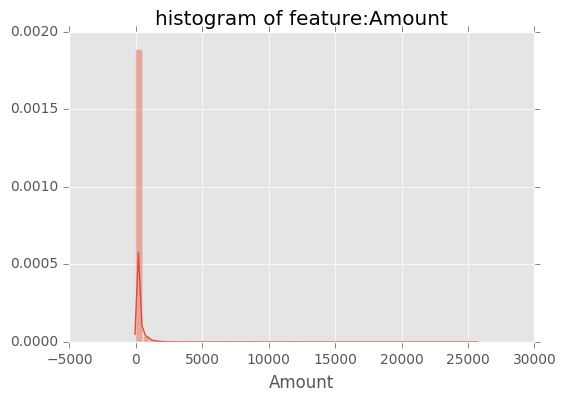

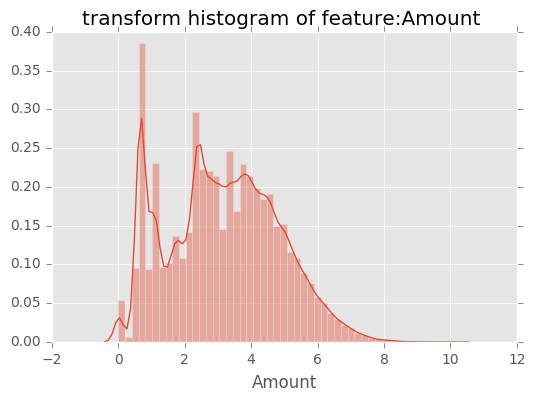

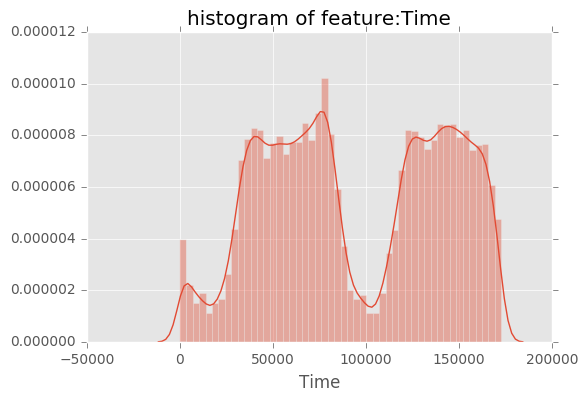

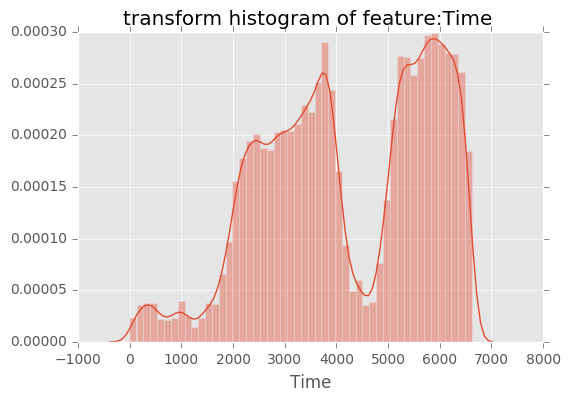

In [59]:
from scipy.stats import boxcox, probplot
def to_normal(data, cols):
    """
    将dataframe中特定列进行正态分布转换
    """
    right_length = 1 # 位移长度，避免存在0影响转换
    for col in cols:
        x = data[col]
        ld, old_r, best_r, best_x = run_boxcox(x, right_length)
        print col, ld, old_r, best_r
        if ld != -100:
            data.loc[:, col] = best_x
    return data.copy()

def run_boxcox(x, right_length):
    """
    选择一个最优的lambda，进行boxcox转换
    :param x:需要转换的某一特征数据
    :param right_length:位移长度，避免存在0影响转换
    return 
        best:最优的lambda;
        old_r:原特征的正态分布相似度;
        best_r:经过最优lambda进行boxcox转换后的
    """
    old_r = qq_test(x)

    #init 
    best_r = old_r
    best_x = x
    best_ld = -100
    lambdas = np.round(np.arange(-2,2.1,0.1),2)
    for ld in lambdas:
        new_x = boxcox(x + right_length, lmbda=ld)
        new_r = qq_test(new_x)
        if new_r > best_r:
            best_r = new_r
            best_x = new_x
            best_ld = ld
    return best_ld,old_r, best_r, best_x

def qq_test(x):
    """
    通过q-q图测试x与正态分布接近程度
    """
    (osm, osr), (slope, intercept, r) = probplot(x)
    return r

"""
test with Amount, Time
"""
new_data = to_normal(data.copy(), ['Amount', 'Time'])
cols = ['Amount', 'Time']
for feature in cols:
    ax = plt.subplot()
    sns.distplot(data[feature], bins=50)
    ax.set_title('histogram of feature:%s' % feature)
    plt.show()
    ax = plt.subplot()
    sns.distplot(new_data[feature], bins=50)
    ax.set_title('transform histogram of feature:%s ' % feature)

    plt.show()

In [11]:
from sklearn.model_selection import train_test_split
def get_train_vaild_test(data, train_rate, valid_rate):
    """
    划分数据集成训练集、验证集、测试集
    :param data:数据集
    :param train_rate: 训练集比例
    :param valid_rate: 验证集占比
    :return 训练集、验证集、测试集
    """
    normal = data[data['Class']==0]
    abnormal = data[data['Class']==1]
    train, normal_test, _, _ = train_test_split(normal, normal, train_size=train_rate, random_state=42) # 白样本，划分 训练集和（验证测试集）
    normal_valid, normal_test, _, _ = train_test_split(normal_test, normal_test, test_size=valid_rate, random_state=42) # 白样本，划分验证、测试集
    anormal_valid, anormal_test, _, _ = train_test_split(abnormal, abnormal, test_size=valid_rate, random_state=42) # 黑样本，划分验证、训练集

    # 合并
    train = train.reset_index(drop=True)
    valid = normal_valid.append(anormal_valid).sample(frac=1).reset_index(drop=True)
    test = normal_test.append(anormal_test).sample(frac=1).reset_index(drop=True)
    print 'Train shape: ', train.shape
    print 'Proportion os anomaly in training set: %.2f\n' % train['Class'].mean()
    print 'Valid shape: ', valid.shape
    print 'Proportion os anomaly in validation set: %.2f\n' % valid['Class'].mean()
    print 'Test shape:, ', test.shape
    print 'Proportion os anomaly in test set: %.2f\n' % test['Class'].mean()
    
    return train, valid, test



# 一、数据探勘


In [12]:
data = pd.read_csv("Dataset/creditcard.csv")

In [14]:
data.info() # 查看数据情况

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  


没有缺失值，均为连续特征。

一共30个特征及一个标记（Class），其中28个特征（V1, V2,...,V28）是PCA处理后的特征，不能看出实际的业务含义。 

另外两个特征为Amount，和Time， Amount为交易金额， Time为该笔交易距第一笔交易的时间

Class 表示标记

In [15]:
# 数据分布概况
desc = data.describe(percentiles=[.75,.99])
desc

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,2.239751e-15,1.673327e-15,-1.254995e-15,8.176030e-16,1.206296e-15,4.913003e-15,1.437666e-15,-3.800113e-16,9.572133e-16,1.039817e-15,6.406703e-16,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
99%,170560.940000,2.237130e+00,3.801811e+00,2.728434e+00,4.248032e+00,3.424903e+00,4.200085e+00,2.696205e+00,2.075973e+00,2.986773e+00,3.253618e+00,2.290583e+00,1.698576e+00,2.513962e+00,2.150300e+00,1.925527e+00,1.874820e+00,2.289928e+00,2.068689e+00,2.262924e+00,2.412190e+00,1.931852e+00,1.530152e+00,1.508703e+00,1.063748e+00,1.203955e+00,1.158698e+00,9.313604e-01,5.411264e-01,1017.970000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


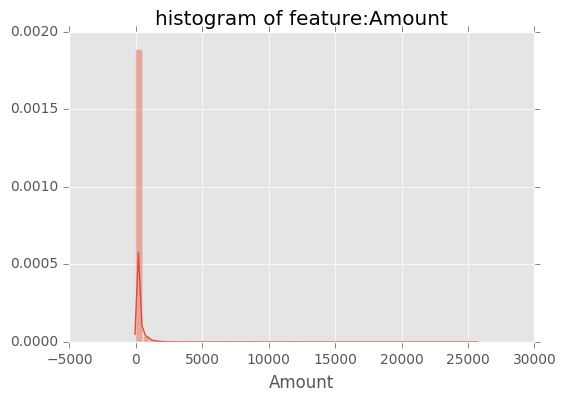

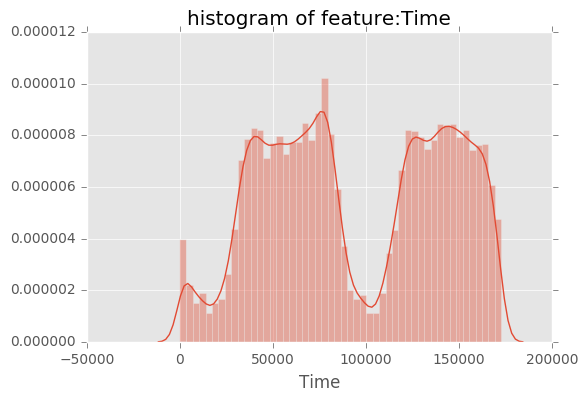

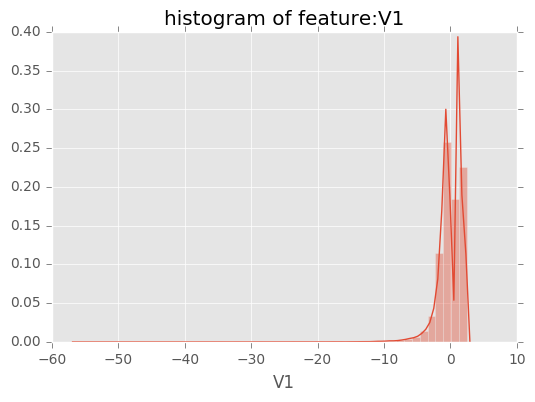

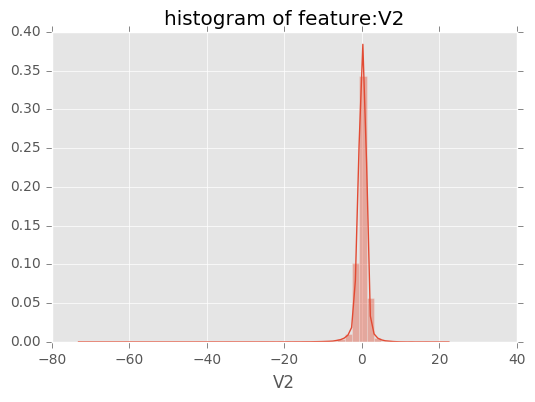

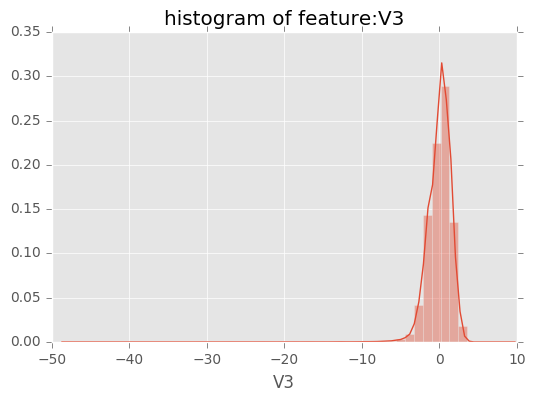

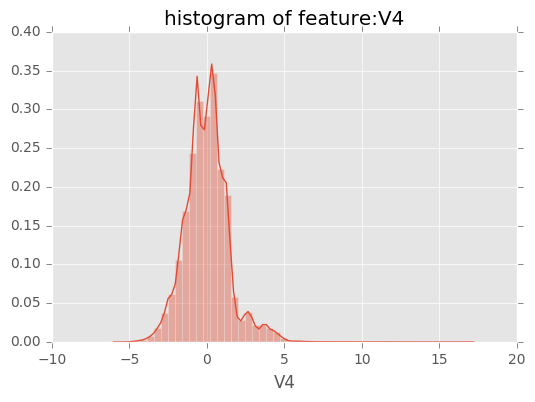

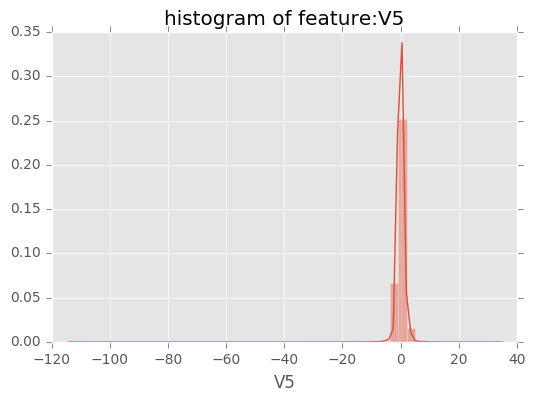

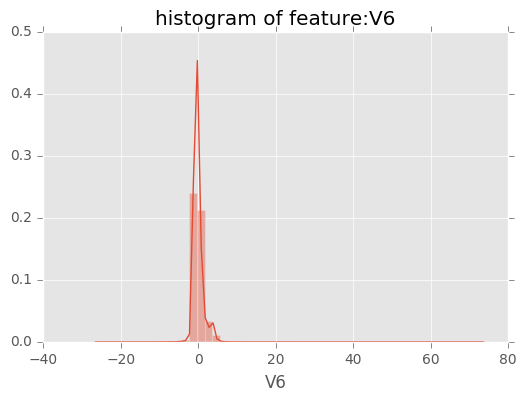

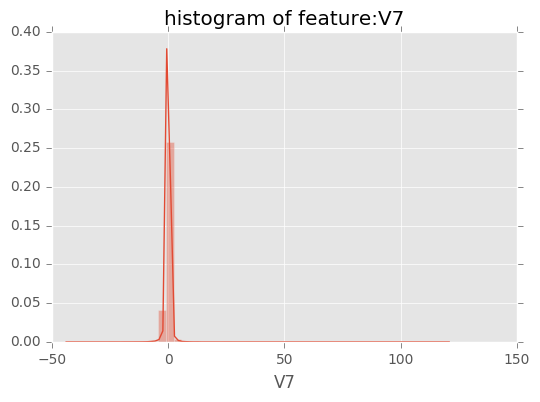

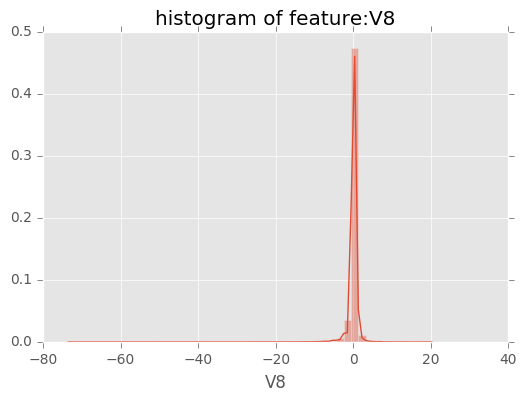

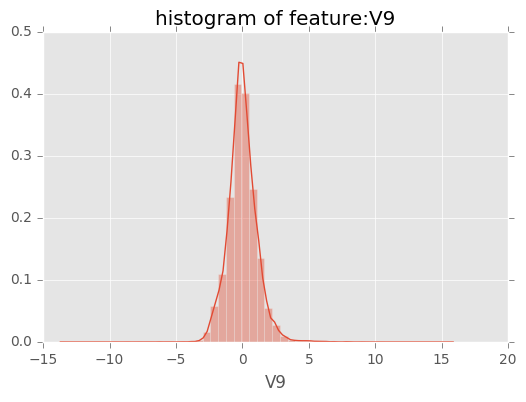

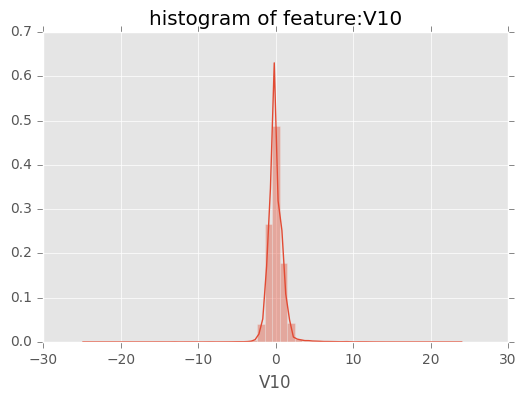

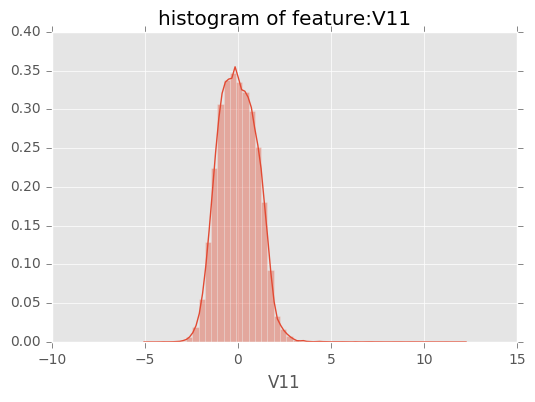

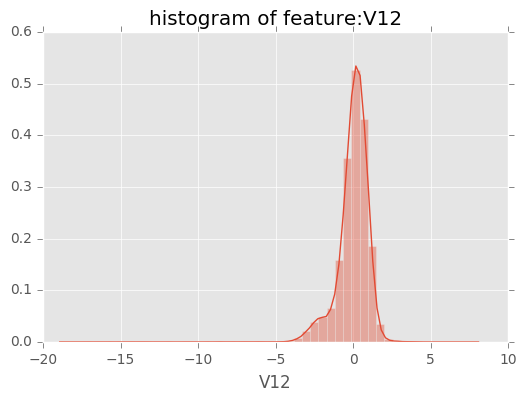

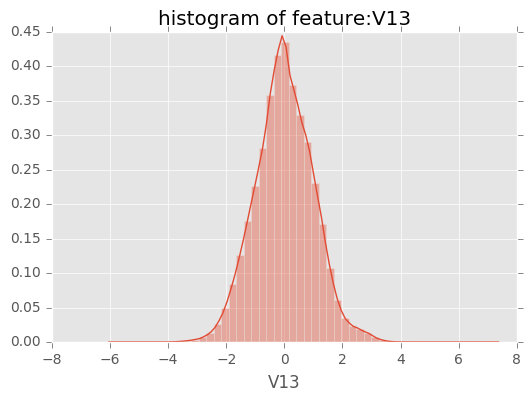

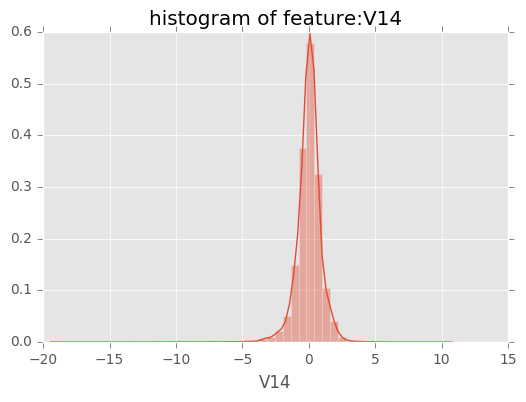

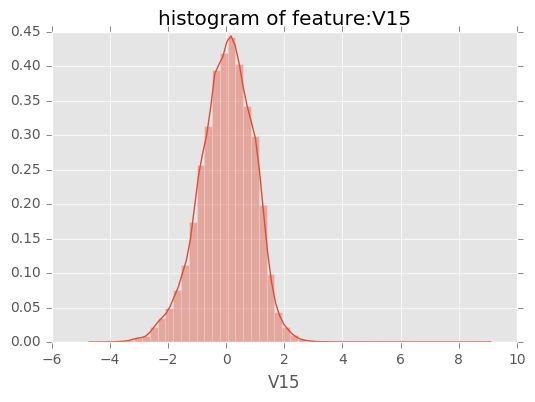

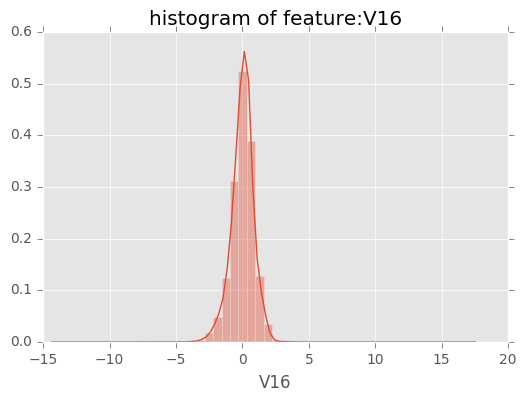

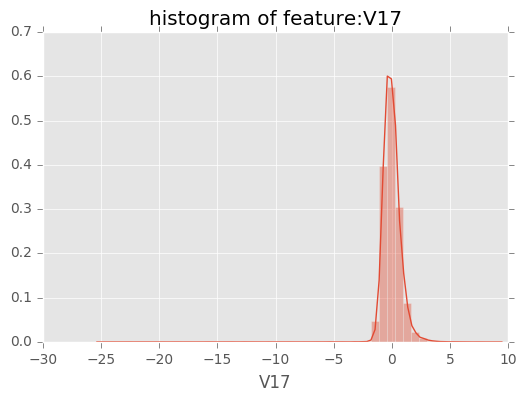

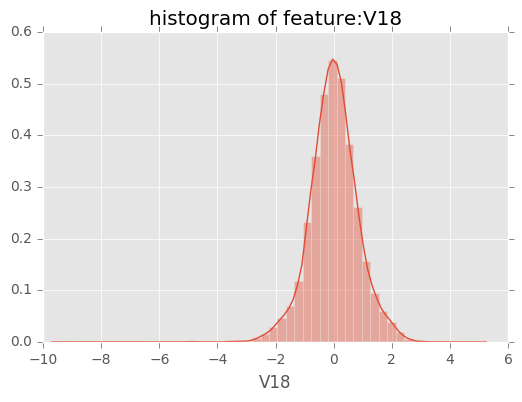

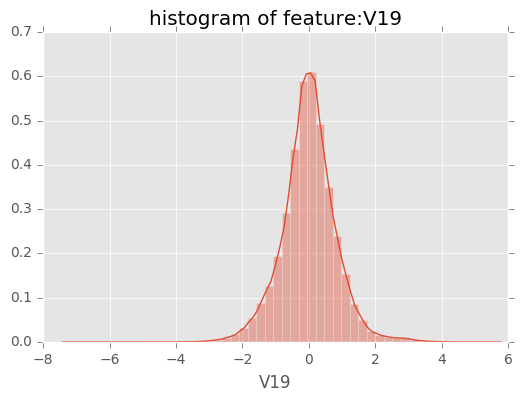

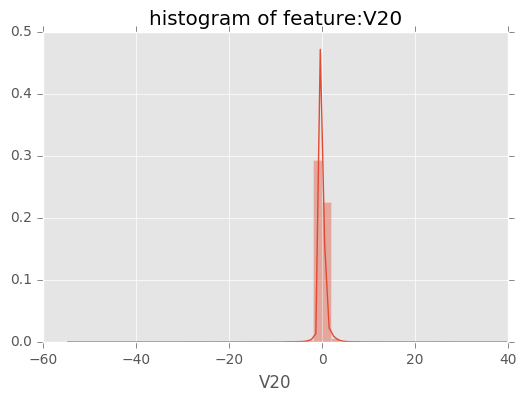

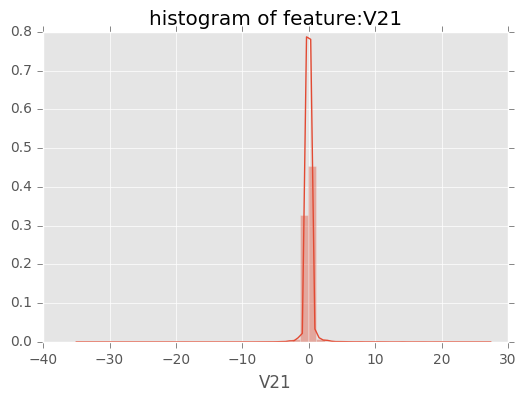

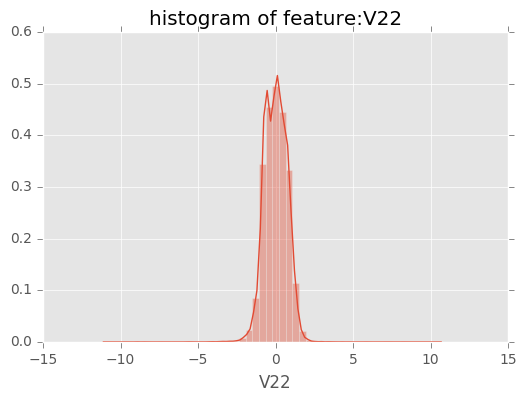

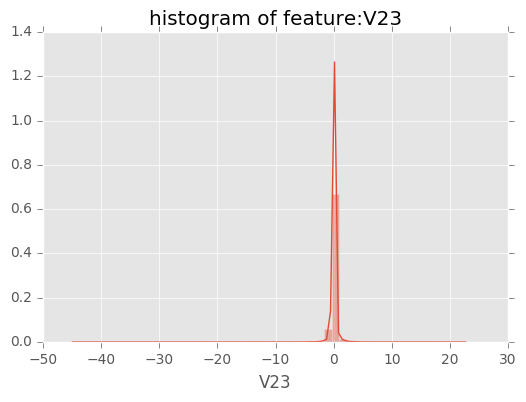

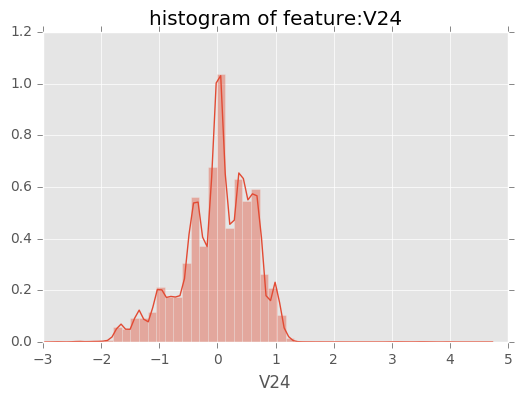

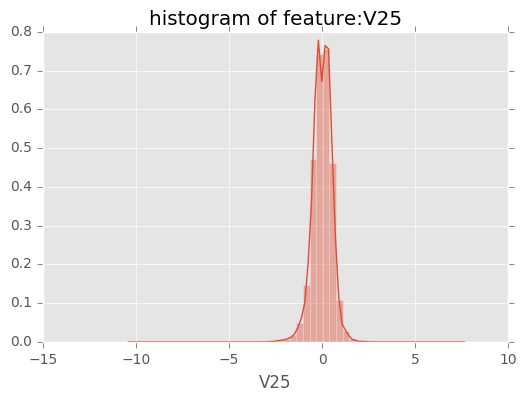

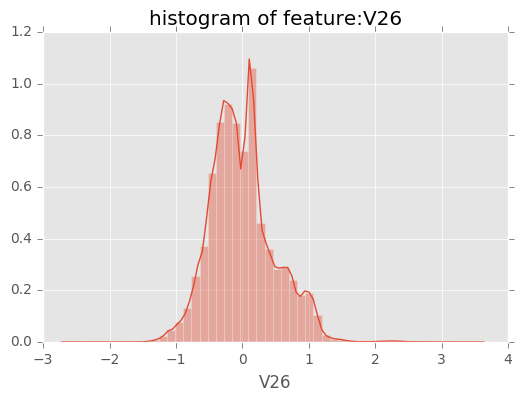

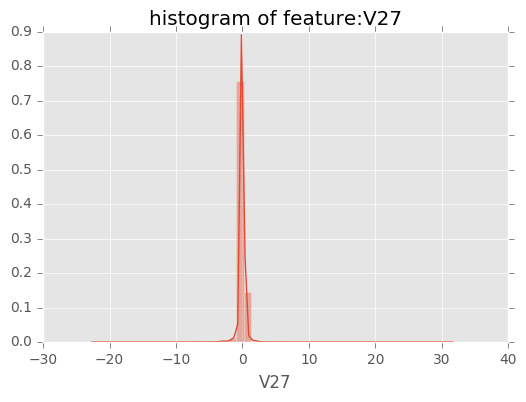

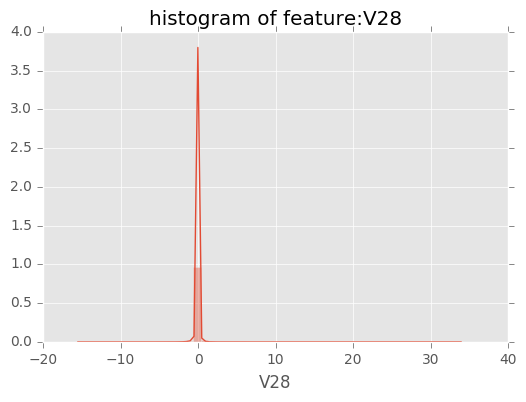

In [57]:
cols = [i for i in data.columns if i not in ['Class', 'Amount']]
cols = ['Amount'] + cols
for feature in cols:
    ax = plt.subplot()
    sns.distplot(data[feature], bins=50)
    ax.set_title('histogram of feature:%s' % feature)
    plt.show()

Time 和 Amount 不服从正态分布，其余近似正态分布

# 二、数据准备
包括 特征转换、 划分数据集


## 特征转换
基于高斯模型，需要把特征转换成近似正态分布

In [58]:
cols = ['Amount', 'Time']
print "需要转换的特征:%s " % ",".join(cols)
data_transformed = to_normal(data.copy(), cols=cols)
data_transformed['Class'] = data['Class'].copy()
data_transformed.head()

需要转换的特征:Amount,Time 
Amount 0.0 0.556713453631 0.990005049063
Time 0.7 0.969562433589 0.972202705455


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,5.014760,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,1.305626,0
2,0.892150,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,5.939276,0
3,0.892150,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,4.824306,0
4,1.653813,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,4.262539,0


## 划分数据集，进行训练、选择阈值、评估
1. 将白样本分成训练集，验证集，测试集三份，每份分别占80%, 10%, 10%
2. 将黑样本分成验证集，测试集两份，每份分别占50%, 50%
3. 合并1 2 中的训练集、验证集、测试集


In [51]:
train, valid, test = get_train_vaild_test(data_transformed.copy(), 0.8, 0.5)
x_valid = valid.drop('Class', axis=1).values
y_valid = valid['Class']
x_valid_normal = valid[valid['Class'] == 0].drop('Class', axis=1).values
x_valid_abnormal = valid[valid['Class'] == 1].drop('Class', axis=1).values

x_test = test.drop('Class', axis=1).values
y_test = test['Class']

Train shape:  (227452, 31)
Proportion os anomaly in training set: 0.00

Valid shape:  (28677, 31)
Proportion os anomaly in validation set: 0.01

Test shape:,  (28678, 31)
Proportion os anomaly in test set: 0.01



# 基于多元高斯模型

In [14]:
from scipy.stats import multivariate_normal

In [60]:
s_time = time.time()
mu = train.drop('Class', axis=1).mean(axis=0).values
sigma = train.drop('Class', axis=1).cov().values
sgm = multivariate_normal(cov=sigma, mean=mu, allow_singular=True)
print "训练时间: %.2f秒" % (time.time()-s_time)
func_name = "logpdf"

训练时间: 1.28秒


In [61]:
#"查看验证集上黑白样本的平均输出值: \n"
get_vaild_score_summary(sgm, func_name)

Normal average score: -40.4704872178
Normal max score: -33.4844426206
Normal min score: -22296.9806815
--
Abnormal average score: -669.344893733
Abnormal max score: -38.0520358537
Abnormal min score: -7924.74671275


max f2: 0.75
best threshold: -281.879194631


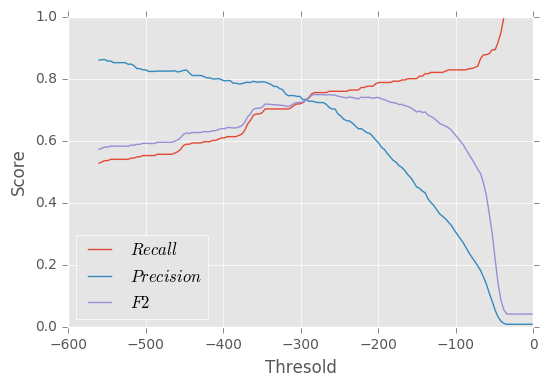

In [62]:
#"\n 选择阈值及绘制评价曲线 \n" 
thresholds = np.linspace(-560,0, 150)
best_threshold = get_best_threshold(sgm, thresholds, func_name)


Test Recall Score 0.789
Test Precision Score 0.705
Test F2 Score 0.770


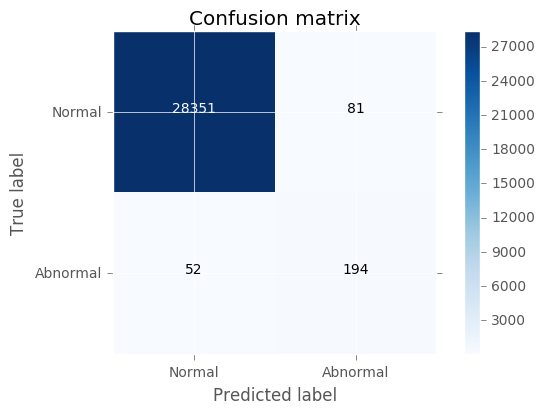

In [63]:
#"选定阈值后，在测试集上的效果 及 给出混淆矩阵"
get_test_result(sgm, best_threshold, func_name)

训练时间可以忽略不计，效果挺不错，f2达到0.77 远超过基准0.6。
（特征不进行转换，F2只有0.343！）

# 基于GMM

In [19]:
from sklearn.mixture import GaussianMixture as GMM

In [52]:
s_time = time.time()
gmm = GMM(n_components=2, n_init=4, random_state=42)
gmm.fit(train.drop('Class', axis=1).values)
print "训练时间: %.2f秒" % (time.time()-s_time)

训练时间: 135.67秒


In [53]:
func_name="score_samples"

In [54]:
#"查看验证集上黑白样本的平均输出值: \n"
get_vaild_score_summary(gmm, func_name)

Normal average score: -33.2590639129
Normal max score: 4.39874962919
Normal min score: -12377.3794866
--
Abnormal average score: -10758.427187
Abnormal max score: -0.610795776907
Abnormal min score: -9857942.51476


max f2: 0.808580858086
best threshold: -282.814070352


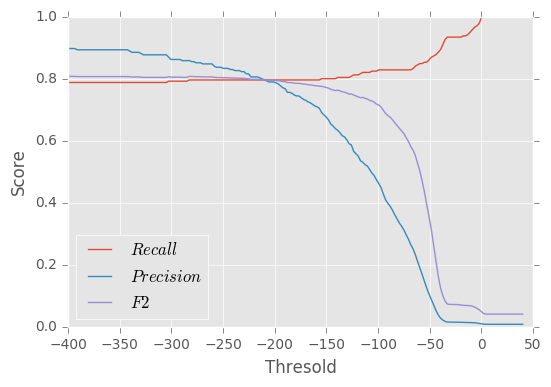

In [55]:
#"\n 选择阈值及绘制评价曲线 \n" 
thresholds = np.linspace(-400,40, 200)
best_threshold = get_best_threshold(gmm, thresholds, func_name)

Test Recall Score 0.809
Test Precision Score 0.819
Test F2 Score 0.811


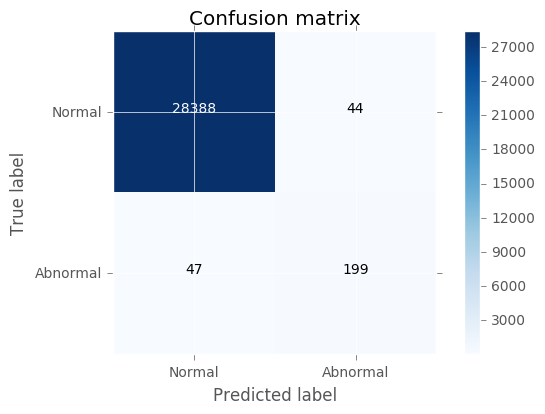

In [56]:
#"选定阈值后，在测试集上的效果 及 给出混淆矩阵"
get_test_result(gmm,best_threshold, func_name)


- n = 2 训练时间115秒， f2达到了8.0
- n = 3 训练时间80秒， f2为0.759
- n = 5 训练时间较长（6分钟）， f2为0.72
n=2时效果比SGM要好，f2达到0.81

组件数过大，效果下降的可能原因：因为仅是拟合白样本，且特征大多服已从正态分布，若组件数过大，可能会造成过拟合。

而不进行转换，n=2时F2可以达到0.826/0.816！ GMM对特征分布的敏感度较低？ 转换特征分布会造成信息的缺失，导致效果不好？

n=3时f2=0.757

# IsolationForest


In [37]:
from sklearn.ensemble import IsolationForest

In [38]:
s_time = time.time()
iforest = IsolationForest(random_state=42, n_estimators=100, contamination=0)
iforest.fit(train.drop("Class", axis=1))
print "训练时间: %.2f秒" % (time.time()-s_time)

训练时间: 27.93秒


In [39]:
func_name = "decision_function"

In [40]:
#"查看验证集上黑白样本的平均输出值: \n"
get_vaild_score_summary(iforest, func_name)


Normal average score: 0.106362645896
Normal max score: 0.146588820215
Normal min score: -0.229294564308
--
Abnormal average score: -0.0584837765145
Abnormal max score: 0.119918648365
Abnormal min score: -0.164662363498


max f2: 0.512903225806
best threshold: -0.0328859060403


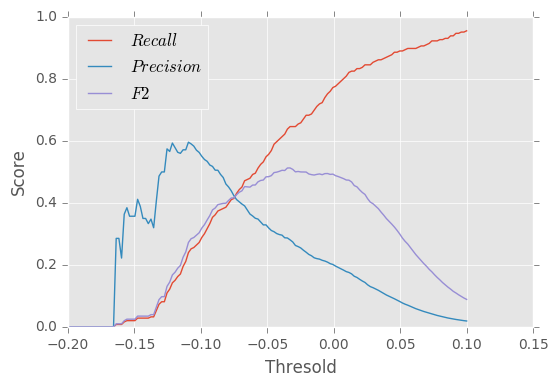

In [41]:
#"\n 选择阈值及绘制评价曲线 \n" 
thresholds = np.linspace(-0.2, 0.1, 150)
best_threshold = get_best_threshold(iforest, thresholds, func_name)

Test Recall Score 0.667
Test Precision Score 0.299
Test F2 Score 0.535


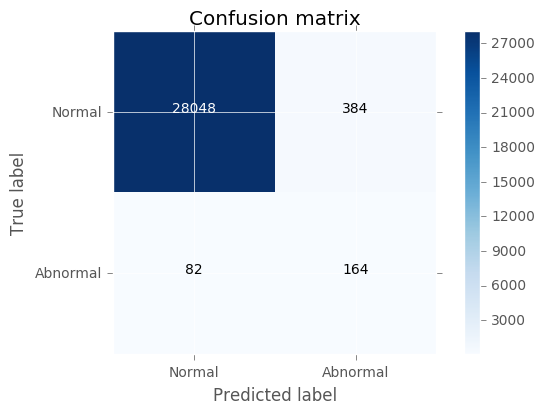

In [42]:
#"选定阈值后，在测试集上的效果 及 给出混淆矩阵"
get_test_result(iforest,best_threshold, func_name)


每次训练30秒，但因为参数过多，故也需要十分钟左右时间调参数。
模型效果一般，f2为0.5，低于基线0.6，是否跟维度过高、连续型特征有关？ 还是需要调参待， 还是只取白样本的训练训练方式？需要进一步研究
(拿不转换的特征，f2达到0.535)

# One-Class-SVM


In [86]:
from sklearn.svm import OneClassSVM
# model

In [ ]:
s_time = time.time()
onesvm = OneClassSVM()
onesvm.fit(data.drop("Class", axis=1).values)
print "训练时间: %.2f秒" % (time.time()-s_time)

训练集过大（十万以上），SVM训练一次较慢。效果也一般。 现在在大样本下一般用得比较少